## Отбор признаков

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     cross_validate)
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [50]:
df = pd.read_csv('datasets/gender_classification.csv')
df['gender_num'] = (df['gender'] == 'Male').astype(int)
df = df.drop(columns=['gender'])

Создадим две переменные , Х содержит признаки (первые 6 столбцов), у содержит целевую переменную (7-й столбец)

In [26]:
X=df.iloc[:,:7]
y=df.iloc[:,7]
X,y

(      long_hair  forehead_width_cm  forehead_height_cm  nose_wide  nose_long  \
 0             1               11.8                 6.1          1          0   
 1             0               14.0                 5.4          0          0   
 2             0               11.8                 6.3          1          1   
 3             0               14.4                 6.1          0          1   
 4             1               13.5                 5.9          0          0   
 ...         ...                ...                 ...        ...        ...   
 4996          1               13.6                 5.1          0          0   
 4997          1               11.9                 5.4          0          0   
 4998          1               12.9                 5.7          0          0   
 4999          1               13.2                 6.2          0          0   
 5000          1               15.4                 5.4          1          1   
 
       lips_thin  distance

gender_num - данные, которые говорят о распределении пола на мужской и женский

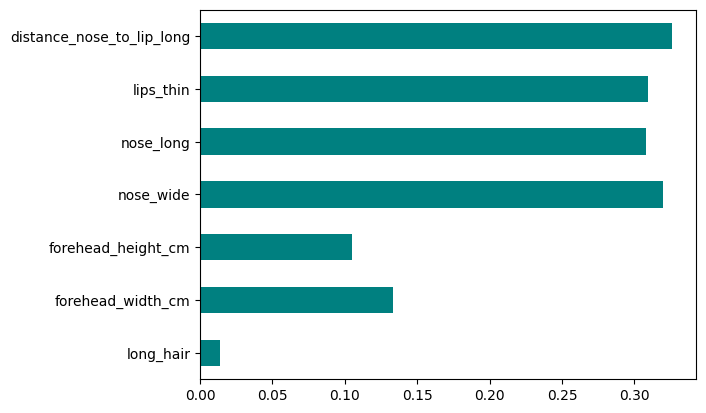

distance_nose_to_lip_long    0.326271
nose_wide                    0.320015
lips_thin                    0.309123
nose_long                    0.307981
forehead_width_cm            0.133237
forehead_height_cm           0.104888
long_hair                    0.013874
dtype: float64

In [27]:
importances = mutual_info_classif(X, y)
feature_importances = pd.Series(importances,X.columns)
feature_importances.plot(kind='barh', color='teal')
plt.show()
feature_importances.sort_values(ascending=False)

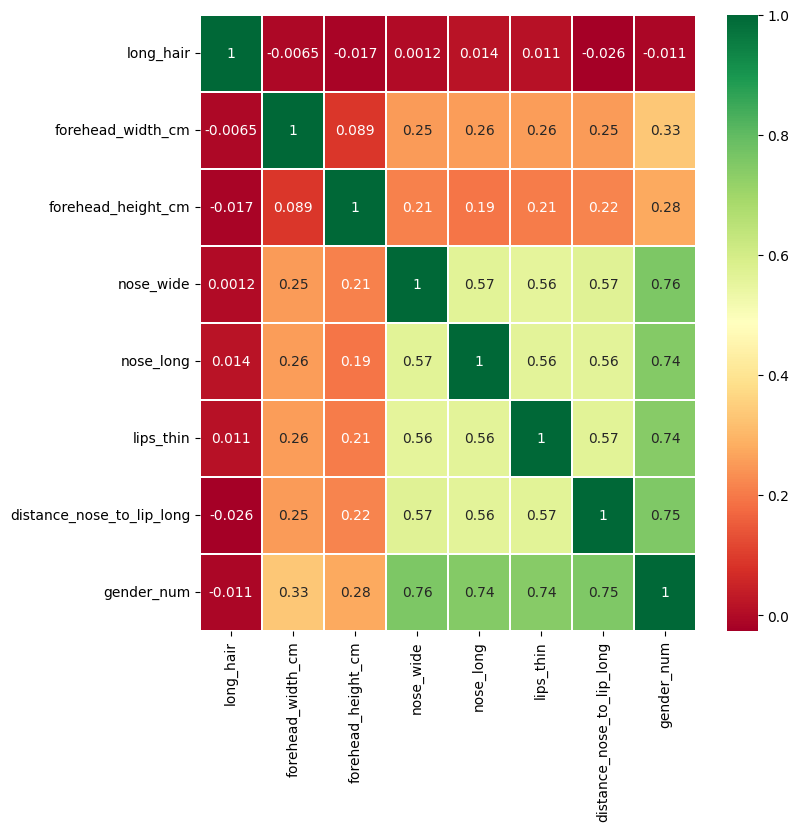

In [28]:
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(8,8)
plt.show()

## Хи-квадрат

Отбор признаков на основе статистики хи-квадрат. Этот метод измеряет зависимость между категориальной зависимой переменной(у) и категориальными признаками (Х). Если X и у независимы, то взаимная информация будет равна нулю. По данным можно увидеть, что самыми взаимосвязанными переменными для gender_num(пол) явялется: nose_wide (ширина носа) и (distance_nose_to_lip_long - расстояние от носа до губ)

                       Specs        Score
3                  nose_wide  1456.149498
6  distance_nose_to_lip_long  1427.916730
5                  lips_thin  1400.647504
4                  nose_long  1362.791251
1          forehead_width_cm    51.906258
2         forehead_height_cm    18.927938
0                  long_hair     0.075583


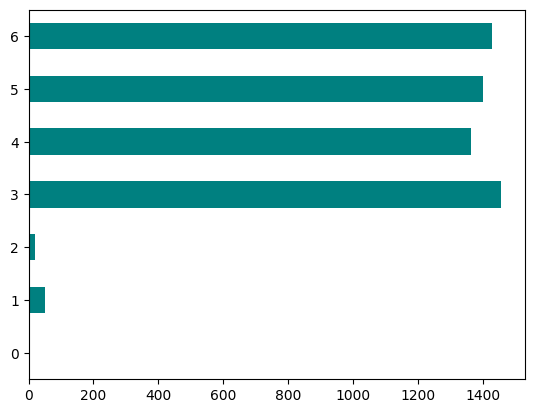

In [29]:
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#объединим два фрейма данных для лучшей визуализации
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #название показателей
print(featureScores.nlargest(11,'Score'))

feature_importances = pd.Series(featureScores['Score'])
feature_importances.plot(kind='barh', color='teal')
plt.show()

## Методы обертки

In [30]:
# разбиваем набор данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df.drop('gender_num', axis=1), df['gender_num'], test_size=0.3,random_state=42)

# создаем список признаков
col_list = X_train.select_dtypes(include=['number']).columns
print(col_list)
print(X_train.shape, y_train.shape)

Index(['long_hair', 'forehead_width_cm', 'forehead_height_cm', 'nose_wide',
       'nose_long', 'lips_thin', 'distance_nose_to_lip_long'],
      dtype='object')
(3500, 7) (3500,)


In [31]:
# вычисляем AUC для модели с одним признаком,
# используя перекрестную проверку
log = LogisticRegression(solver='liblinear')
auc=cross_val_score(log, X_train, y_train, cv=5, scoring='roc_auc')

# превращаем список со значениями AUC в серию
auc_values = pd.Series(auc)
print(auc_values)

0    0.993363
1    0.993771
2    0.993192
3    0.995106
4    0.993869
dtype: float64


In [32]:
# сортируем по убыванию
auc_values = auc_values.sort_values(ascending=False)
auc_values

3    0.995106
4    0.993869
1    0.993771
0    0.993363
2    0.993192
dtype: float64

In [33]:
# формитруем датасет только из информативных показателей
x_1=X.iloc[:,auc_values.index]#3
x_1

,nose_wide,nose_long,forehead_width_cm,long_hair,forehead_height_cm
0,1,0,11.8,1,6.1
1,0,0,14.0,0,5.4
2,1,1,11.8,0,6.3
3,0,1,14.4,0,6.1
4,0,0,13.5,1,5.9
...,...,...,...,...,...
4996,0,0,13.6,1,5.1
4997,0,0,11.9,1,5.4
4998,0,0,12.9,1,5.7
4999,0,0,13.2,1,6.2


## Рекурсивное исключение признаков

Это метод рекурсивного исключения признаков (RFE) логистической регрессией для выбора наиболее значимых признаков.

In [34]:
threshold = 5 # the number of most relevant features

lr = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=42, n_jobs=-1, max_iter=1000)

rfe = RFE(lr, n_features_to_select=5)
rfe=rfe.fit(X, y)
# X_train, y_train - входные и выходные данные с обучающей выборки соответственно.
selector_ind = rfe.get_support()
df_rfe = X.iloc[:, selector_ind]
print(df_rfe.columns)

Index(['forehead_height_cm', 'nose_wide', 'nose_long', 'lips_thin',
       'distance_nose_to_lip_long'],
      dtype='object')


Этот подход позволяет оценить, какие признаки вносят наибольший вклад в модель на основе выбранных метрик качества.

In [35]:
# Теперь вычислим важности признаков на основе информационного выигрыша.
# создаем экземляр класса LGBMClassifier
model_all_features = LGBMClassifier(
    random_state=42, learning_rate=0.01,
    n_estimators=300, bagging_fraction=0.5,
    feature_fraction=1, lambda_l1=10,
    importance_type='gain')
params={'verbose': -1}
model_all_features.set_params(**params)

# выполняем перекрестную проверку и сохраняем результат
# с помощью функции cross_validate()
output = cross_validate(
    model_all_features, X_train, y_train, cv=5,
    scoring='roc_auc', return_estimator=True)

# создаем список fi, в который будем сохранять
# важности признаков, и сохраняем в него важности,
# рассчитанные для каждой из моделей
fi = []
for estimator in output['estimator']:
    fi.append(estimator.feature_importances_)

# преобразовываем список в датафрейм, индексы в котором
# будут именами наших переменных
fi = pd.DataFrame(
    np.array(fi).T,
    columns=['importance ' + str(idx)
             for idx in range(len(fi))],
    index=X_train.columns)
# вычисляем усредненные важности и добавляем столбец с ними
fi['mean_importance'] = fi.mean(axis=1)
# смотрим полученный датафрейм
fi

,importance 0,importance 1,importance 2,importance 3,importance 4,mean_importance
long_hair,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
forehead_width_cm,4049.483256,3056.854515,1765.777798,1658.032561,3150.856105,2736.200847
forehead_height_cm,1735.333922,1662.507959,1248.362817,1041.275487,1591.035279,1455.703093
nose_wide,31858.229099,26306.765334,23938.736908,18549.785301,47295.977016,29589.898732
nose_long,22865.340586,33115.664646,49863.045372,38423.252571,17384.516485,32330.363932
lips_thin,18888.572769,31308.363762,19981.057444,25509.834205,21248.521761,23387.269988
distance_nose_to_lip_long,72894.551389,56307.368113,54504.316649,66412.093527,60954.085170,62214.482970


## Регуляризация LASSO (L1).
Регуляризация состоит в добавлении штрафа (penalty) к различным параметрам модели во избежание чрезмерной подгонки. При регуляризации линейной модели штраф применяется к коэффициентам, умножающим каждый из предикторов. Lasso-регуляризация обладает свойством, позволяющим уменьшить некоторые коэффициенты до нуля. Следовательно, такие “фичи” можно будет просто удалить из модели.

![img](https://drive.google.com/uc?id=1pAFQRa8I_-twxgh_2qbkrjJHoezkrY7i)

In [36]:
# Устанавливаем наш параметр регуляризации C=1
logistic = LogisticRegression(C=1, penalty="l1", solver='liblinear', random_state=7).fit(X, y)
# Где X, y - входные и выходные данные соответственно.
model = SelectFromModel(logistic, prefit=True)

X_new = model.transform(X)

# выводим финальную оценку прогнозирования.
selector_ind = model.get_support()
df_rfe1 = X.iloc[:, selector_ind]
print(df_rfe1.columns)
X_new

Index(['long_hair', 'forehead_width_cm', 'forehead_height_cm', 'nose_wide',
       'nose_long', 'lips_thin', 'distance_nose_to_lip_long'],
      dtype='object')


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


array([[ 1. , 11.8,  6.1, ...,  0. ,  1. ,  1. ],
       [ 0. , 14. ,  5.4, ...,  0. ,  1. ,  0. ],
       [ 0. , 11.8,  6.3, ...,  1. ,  1. ,  1. ],
       ...,
       [ 1. , 12.9,  5.7, ...,  0. ,  0. ,  0. ],
       [ 1. , 13.2,  6.2, ...,  0. ,  0. ,  0. ],
       [ 1. , 15.4,  5.4, ...,  1. ,  1. ,  1. ]])

## Регуляризация Тихонова (L2).

Суть в том, что чересчур тяжёлые весовые коэффициенты «отталкивают» нашу линию наилучшего соответствия, построенную на основе минимизации квадрата ошибок, от основной тендеции.

![img](https://drive.google.com/uc?id=1_B9TGeTVXUK5F8iPnF1JJL-x1GSw7BXZ)

In [37]:
n_samples, n_features = 10, 5
rng = np.random.RandomState(0)
y = rng.randn(n_samples)
X = rng.randn(n_samples, n_features)
clf = Ridge(alpha=1.0)
clf.fit(X, y)
clf.coef_

array([ 0.51088991,  0.03729032, -0.65075201,  0.0930311 ,  0.93380887])

**Как видно из конечных наборов функций, мы получаем разные результаты для разных подходов, поэтому нет определенной истины в выборе функций.**

Методы фильтрации часто являются одномерными и учитывают признаки независимо или с учетом зависимой переменной. Однако это не всегда правильное предположение. Иногда функция сама по себе не имеет смысла, в то время как она может улучшить модель с помощью комбинаций других функций. Таким образом, подобные ситуации упускаются из виду в методах фильтрации. Кроме того, оценка статистических измерений для выбора признаков не способствует производительности модели, поэтому может не повысить точность модели. С другой стороны, эти подходы просты и выгодны по сравнению с другими в отношении времени обучения.

Методы-оболочки используют итеративные процедуры поиска и используются вместе с моделью. В отличие от методов фильтрации, он учитывает комбинации объектов и возвращает подмножество объектов. Это может быть реализовано жадным или нежадным способом. Жадные подходы, такие как RFE, могут столкнуться с такими проблемами, как попадание в ловушку локальных оптимумов. Как правило, они работают медленнее, чем методы фильтрации, поскольку требуют больших объемов вычислений с учетом итеративного подхода.

Встроенные методы работают быстрее, чем методы-оболочки, поскольку процесс выбора встроен в процесс подгонки модели. Они также обеспечивают прямую связь между выбором функций и производительностью модели. Таким образом, вы можете получить более удовлетворительные результаты с помощью встроенных методов. Одним из недостатков этого подхода является то, что он зависит от модели. Данные могут лучше соответствовать модели, которая неудобна для встроенных видов выбора функций.

## Комбинирование нескольких методов для отбора признаков

In [38]:
# разбиваем набор данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df.drop('gender_num', axis=1), df['gender_num'], test_size=0.3,random_state=42)

# Сначала ищем оптимальный темп обучения для зафиксированного количества деревьев

# создаем экземляр класса LGBMClassifier
lgbm_model = LGBMClassifier(random_state=42,n_estimators=300)
params={'verbose': -1}
lgbm_model.set_params(**params)

# задаем сетку гиперпараметров
param_grid = {
              'learning_rate': [0.01, 0.05, 0.1]
              }
# создаем экземпляр класса GridSearchCV, передав
# конвейер, сетку гиперпараметров и указав
# количество блоков перекрестной проверки
gs = GridSearchCV(lgbm_model,param_grid, scoring='roc_auc', cv=5)

# выполняем поиск по всем значениям сетки
gs.fit(X_train, y_train);

# смотрим наилучшие значения гиперпараметров
print("Наилучшие значения гиперпараметров: {}".format( gs.best_params_))
# смотрим наилучшее значение AUC
print("Наилучшее значение AUC: {:.3f}".format(gs.best_score_))

Наилучшие значения гиперпараметров: {'learning_rate': 0.05}
Наилучшее значение AUC: 0.997


In [39]:
# Теперь ищем с помощью обычного поиска по сетке оптимальные значения гиперпараметров
# Гиперпараметр lambda_l1 - задает штрафной коэффициент перед L1-нормой вектора весов листьев (по умолчанию 0).
# Гиперпараметр bagging_ fraction - задает случайный отбор наблюдений без возвращения.
# Он может принимать значения от 0 до 1
# Гиперпараметр feature_fraction - задает случайный отбор признаков для каждого дерева.
# Он может принимать значения от 0 до 1

# создаем экземляр класса LGBMClassifier
lgbm_model2 = LGBMClassifier(random_state=42,
                             n_estimators=300,
                             learning_rate=0.01)
params={'verbose': -1}
lgbm_model2.set_params(**params)

# задаем сетку гиперпараметров
param_grid2 = {
    'lambda_l1': [0, 10],
    'bagging_fraction': [0.5, 1],
    'feature_fraction': [0.5, 1]
}

# создаем экземпляр класса GridSearchCV, передав
# конвейер, сетку гиперпараметров и указав
# количество блоков перекрестной проверки
gs2 = GridSearchCV(lgbm_model2,
                   param_grid2,
                   scoring='roc_auc',
                   cv=5)

# выполняем поиск по всем значениям сетки
gs2.fit(X_train, y_train)

# смотрим наилучшие значения гиперпараметров
print('Наилучшие значения гиперпараметров: {}'.format(gs2.best_params_))
# смотрим наилучшее значение AUC
print('Наилучшее значение AUC: {:.3f}'.format(gs2.best_score_))

Наилучшие значения гиперпараметров: {'bagging_fraction': 0.5, 'feature_fraction': 0.5, 'lambda_l1': 0}
Наилучшее значение AUC: 0.997


In [40]:
# Теперь вычислим важности признаков на основе информационного выигрыша.
# создаем экземляр класса LGBMClassifier
model_all_features = LGBMClassifier(
    random_state=42, learning_rate=0.01,
    n_estimators=300, bagging_fraction=0.5,
    feature_fraction=1, lambda_l1=10,
    importance_type='gain')
params={'verbose': -1}
model_all_features.set_params(**params)

# выполняем перекрестную проверку и сохраняем результат
# с помощью функции cross_validate()
output = cross_validate(
    model_all_features, X_train, y_train, cv=5,
    scoring='roc_auc', return_estimator=True)

# создаем список fi, в который будем сохранять
# важности признаков, и сохраняем в него важности,
# рассчитанные для каждой из моделей
fi = []
for estimator in output['estimator']:
    fi.append(estimator.feature_importances_)

# преобразовываем список в датафрейм, индексы в котором
# будут именами наших переменных
fi = pd.DataFrame(
    np.array(fi).T,
    columns=['importance ' + str(idx)
             for idx in range(len(fi))],
    index=X_train.columns)
# вычисляем усредненные важности и добавляем столбец с ними
fi['mean_importance'] = fi.mean(axis=1)
# смотрим полученный датафрейм
fi

,importance 0,importance 1,importance 2,importance 3,importance 4,mean_importance
long_hair,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
forehead_width_cm,4049.483256,3056.854515,1765.777798,1658.032561,3150.856105,2736.200847
forehead_height_cm,1735.333922,1662.507959,1248.362817,1041.275487,1591.035279,1455.703093
nose_wide,31858.229099,26306.765334,23938.736908,18549.785301,47295.977016,29589.898732
nose_long,22865.340586,33115.664646,49863.045372,38423.252571,17384.516485,32330.363932
lips_thin,18888.572769,31308.363762,19981.057444,25509.834205,21248.521761,23387.269988
distance_nose_to_lip_long,72894.551389,56307.368113,54504.316649,66412.093527,60954.085170,62214.482970


Здесь мы видим, что некоторые признаки имеют нулевые или высокие важности.

In [41]:
# записываем серию, в которой индексные метки - признаки,
# значения - важности
features = fi['mean_importance']
# сортируем индексные метки по возрастанию важностей
features = features.sort_values(ascending=True)
features

long_hair                        0.000000
forehead_height_cm            1455.703093
forehead_width_cm             2736.200847
lips_thin                    23387.269988
nose_wide                    29589.898732
nose_long                    32330.363932
distance_nose_to_lip_long    62214.482970
Name: mean_importance, dtype: float64

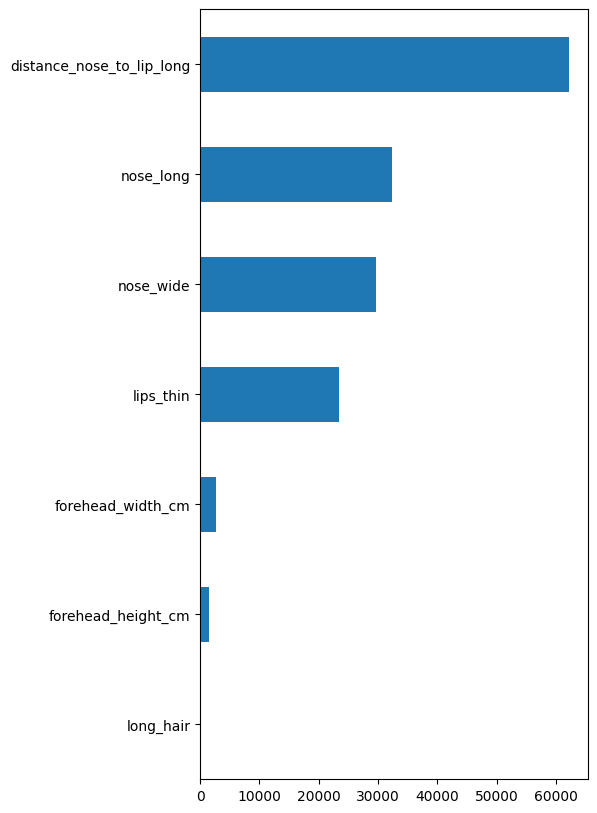

In [42]:
# выводим график усредненных важностей
features.plot.barh(figsize=(5, 10));

In [43]:
# создаем список признаков
features = list(features.index)
features

['long_hair',
 'forehead_height_cm',
 'forehead_width_cm',
 'lips_thin',
 'nose_wide',
 'nose_long',
 'distance_nose_to_lip_long']

In [44]:
# вычисляем оценку AUC-ROC, усредненную по 5 проверочным
# блокам перекрестной проверки (5 моделям со всеми
# признаками)
auc_score_all = output['test_score'].mean()
auc_score_all

0.9963141167422643

In [48]:
# задаем пороговое значение разницы AUC
tol = 0.0001

print("выполнение последовательного удаления признаков")

# создаем список, в который будем
# записывать удаляемые признаки
features_to_remove = []
# создаем список, в который будем
# записывать значение AUC
auc_score_mean_list = []
# создаем список, в который будем
# записывать разницу AUC
diff_auc_list = []

# задаем счетчик для оценки прогресса
count = 1

# итерируем по всем признакам, признаки упорядочены по
# возрастанию важности на основе информационного выигрыша
for feature in features:
    print()
    print("проверяемый признак: ", feature, " признак ", count,
          " из ", len(features))
    count = count + 1

    # создаем экземляр класса LGBMClassifier
    model = LGBMClassifier(
        random_state=42, learning_rate=0.01,
        n_estimators=300, bagging_fraction=0.5,
        feature_fraction=1, lambda_l1=10)

    params={'verbose': -1}
    model.set_params(**params)

    # обучаем модели со всеми признаками минус уже удаленные признаки
    # (берем их из списка удаляемых признаков) и оцениваемый признак
    auc_scores = cross_val_score(
        model,
        X_train.drop(features_to_remove + [feature], axis=1),
        y_train,
        scoring='roc_auc',
        cv=5)
 # вычисляем AUC, усредненный по проверочным блокам
    # перекрестной проверки
    auc_score_mean = auc_scores.mean()

    # печатаем усредненное значение AUC
    print("AUC модели после удаления={}".format((auc_score_mean)))

    # добавляем усредненное значение AUC в список
    auc_score_mean_list.append(auc_score_mean)

    # печатаем AUC модели со всеми признаками
    # (опорное значение AUC)
    print("AUC модели со всеми признаками={}".format((auc_score_all)))

    # определяем разницу AUC (если отрицательное значение
    # - удаление признака улучшило AUC)
    diff_auc = auc_score_all - auc_score_mean

    # записываем разницу AUC в список
    diff_auc_list.append(diff_auc)

    # сравниваем разницу AUC с порогом, заданным заранее
    # если разница AUC больше или равна порогу, сохраняем
    if diff_auc >= tol:
        print("Разница AUC={}".format(diff_auc))
        print("сохраняем: ", feature)
        print

    # если разница AUC меньше порога, удаляем
    else:
        print("Разница AUC={}".format(diff_auc))
        print("удаляем: ", feature)
        print

        # если разница AUC меньше порога и мы удаляем признак,
        # мы в качестве нового опорного значения AUC задаем
        # значение AUC для модели с оставшимися признаками
        auc_score_all = auc_score_mean
 # добавляем удаляемый признак в список
        features_to_remove.append(feature)

# формируем датафрейм
df2 = pd.DataFrame({'feature': features,
                   'auc_score_mean': auc_score_mean_list,
                   'diff_auc_score': diff_auc_list})

# цикл завершен, вычисляем количество
# удаленных признаков
print("общее количество признаков для удаления: ",
      len(features_to_remove))

# определяем признаки, которые мы хотим сохранить (не удаляем)
features_to_keep = [x for x in features
                    if x not in features_to_remove]
print("общее количество признаков для сохранения: ",
      len(features_to_keep))

выполнение последовательного удаления признаков

проверяемый признак:  long_hair  признак  1  из  7
AUC модели после удаления=0.9963141167422643
AUC модели со всеми признаками=0.9963141167422643
Разница AUC=0.0
удаляем:  long_hair

проверяемый признак:  forehead_height_cm  признак  2  из  7
AUC модели после удаления=0.9955197908290334
AUC модели со всеми признаками=0.9963141167422643
Разница AUC=0.0007943259132309199
сохраняем:  forehead_height_cm

проверяемый признак:  forehead_width_cm  признак  3  из  7
AUC модели после удаления=0.9946871082789637
AUC модели со всеми признаками=0.9963141167422643
Разница AUC=0.001627008463300661
сохраняем:  forehead_width_cm

проверяемый признак:  lips_thin  признак  4  из  7
AUC модели после удаления=0.9921710651697209
AUC модели со всеми признаками=0.9963141167422643
Разница AUC=0.004143051572543466
сохраняем:  lips_thin

проверяемый признак:  nose_wide  признак  5  из  7
AUC модели после удаления=0.990628937344112
AUC модели со всеми признаками=0

In [49]:
df2

,feature,auc_score_mean,diff_auc_score
0,long_hair,0.996314,0.000000
1,forehead_height_cm,0.995520,0.000794
2,forehead_width_cm,0.994687,0.001627
3,lips_thin,0.992171,0.004143
4,nose_wide,0.990629,0.005685
5,nose_long,0.991551,0.004764
6,distance_nose_to_lip_long,0.991049,0.005266


In [52]:
dgg_new = []
for col in features_to_keep:
    dgg_new.append(df[col])
dff1 = pd.DataFrame(dgg_new).T
dff1.to_csv(path_or_buf='datasets/gender_classification_1.csv',index=False)
dff1

,forehead_height_cm,forehead_width_cm,lips_thin,nose_wide,nose_long,distance_nose_to_lip_long
0,6.1,11.8,1.0,1.0,0.0,1.0
1,5.4,14.0,1.0,0.0,0.0,0.0
2,6.3,11.8,1.0,1.0,1.0,1.0
3,6.1,14.4,1.0,0.0,1.0,1.0
4,5.9,13.5,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
4996,5.1,13.6,0.0,0.0,0.0,0.0
4997,5.4,11.9,0.0,0.0,0.0,0.0
4998,5.7,12.9,0.0,0.0,0.0,0.0
4999,6.2,13.2,0.0,0.0,0.0,0.0
